In [153]:
import matplotlib.pyplot as plt
import pandas as pd
import csv
import os
import scipy.io
import json
import numpy as np
from format_data import *
from utils import *
import pickle
import math

t_pre = 0.2#0.2
t_post = 0.30#0.300
bin_width = 0.005
# Créer les bins de temps"
psth_bins = np.arange(-t_pre, t_post, bin_width)

In [154]:
path = '/auto/data2/eTheremin/MUROLS/MUROLS_20230218/MUROLS_20230218_SESSION_01/'
#tt = np.load(path+'tt.npz')

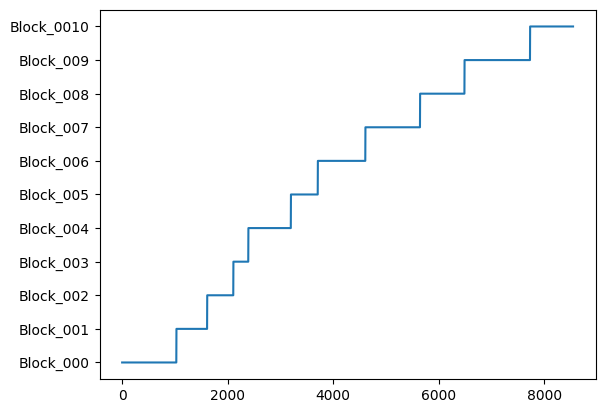

In [155]:
tt_path = path+'headstage_0/tt.pkl'
with open(tt_path, 'rb') as file:
    tt = pickle.load(file)
plt.plot(tt['block'])

In [156]:
data = np.load(path+'headstage_0/data_0.005.npy', allow_pickle=True)
features = np.load(path+'headstage_0/features_0.005.npy', allow_pickle=True)
try: 
    gc = np.load(path+'headstage_0/good_clusters.npy', allow_pickle=True)
except:
    gc = np.arange(0,32)

In [157]:
features

array([{'Played_frequency': 0.0, 'Condition': -1.0, 'Block': 0.0, 'Frequency_changes': False, 'Mock_frequency': 0.0, 'Mock_change': False},
       {'Played_frequency': 0.0, 'Condition': -1.0, 'Block': 0.0, 'Frequency_changes': False, 'Mock_frequency': 0.0, 'Mock_change': False},
       {'Played_frequency': 0.0, 'Condition': -1.0, 'Block': 0.0, 'Frequency_changes': False, 'Mock_frequency': 0.0, 'Mock_change': False},
       ...,
       {'Played_frequency': 2000.0, 'Condition': -1.0, 'Block': 0.0, 'Frequency_changes': False, 'Mock_frequency': 617.0, 'Mock_change': False},
       {'Played_frequency': 2000.0, 'Condition': -1.0, 'Block': 0.0, 'Frequency_changes': False, 'Mock_frequency': 617.0, 'Mock_change': False},
       {'Played_frequency': 2000.0, 'Condition': -1.0, 'Block': 0.0, 'Frequency_changes': False, 'Mock_frequency': 617.0, 'Mock_change': False}],
      dtype=object)

In [163]:
tail = True
n_block = int(np.max([elt['Block'] for elt in features]))
print(n_block+1)
m_tracking, m_playback = [], []
if tail:
    warmup = get_psth_in_block(data, features, t_pre, t_post, bin_width, gc, 0, 'tail')
    warmdown = get_psth_in_block(data, features, t_pre, t_post, bin_width, gc, n_block+1, 'tail')

    c_warmup = np.nanmean(warmup, axis=1)
    m_warmup = np.nanmean(c_warmup, axis=0)

    c_warmdown= np.nanmean(warmdown, axis=1)
    m_warmdown = np.nanmean(c_warmdown, axis=0)
for i in range(1, n_block):
    tracking = get_psth_in_block(data, features, t_pre, t_post, bin_width, gc, i, 'tracking')
    playback = get_psth_in_block(data, features, t_pre, t_post, bin_width, gc, i, 'playback')
    #playback = get_psth_in_block(data, features, t_pre, t_post, bin_width, gc, i, 'playback')
    c_tracking = np.nanmean(tracking, axis=1)
    c_playback = np.nanmean(playback, axis=1)
    m_tracking.append(np.nanmean(c_tracking, axis=0))
    m_playback.append(np.nanmean(c_playback, axis=0))



10


In [161]:
m_warmdown

nan

ValueError: x and y must have same first dimension, but have shapes (100,) and (1,)

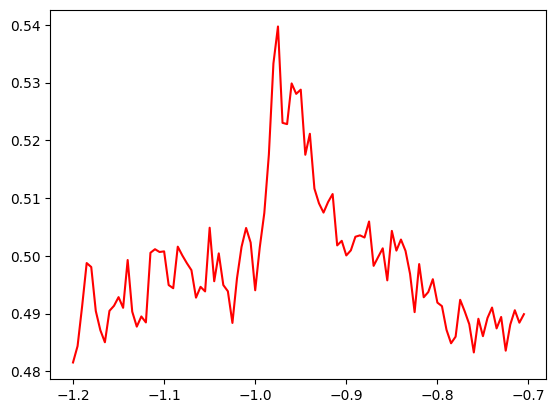

In [160]:
x_tr = np.arange(0, 0 + (n_block+1) , 1)
x_pb = np.arange(0.5, 0.5 + n_block , 1)
tail=True
if tail : 
    plt.plot(psth_bins+np.full_like(psth_bins,-1), m_warmup, c = 'red')
    plt.plot(psth_bins+np.full_like(psth_bins,x_tr[-1]), m_warmdown, c = 'red')

for i, elt in enumerate(m_tracking) : 
    plt.plot(psth_bins+np.full_like(psth_bins,x_tr[i]), elt, c = 'red')
    plt.plot(psth_bins+np.full_like(psth_bins,x_pb[i]), m_playback[i], c = 'black')
plt.xlabel('block [s]')
plt.ylabel('[spikes/s]')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend()
plt.title('Evolution of psth block by block')
plt.show()


In [137]:
tracking = get_psth(data, features, t_pre, t_post, bin_width, gc, 'tracking')
playback = get_psth(data, features, t_pre, t_post, bin_width, gc, 'playback')

In [138]:
cluster = 4
tr_c0 = tracking[cluster]
tr_labels = np.zeros(len(tr_c0))
pb_c0 = playback[cluster]
pb_labels = np.ones(len(pb_c0))

c0 = np.vstack((tr_c0, pb_c0))
condition = np.hstack((tr_labels, pb_labels))

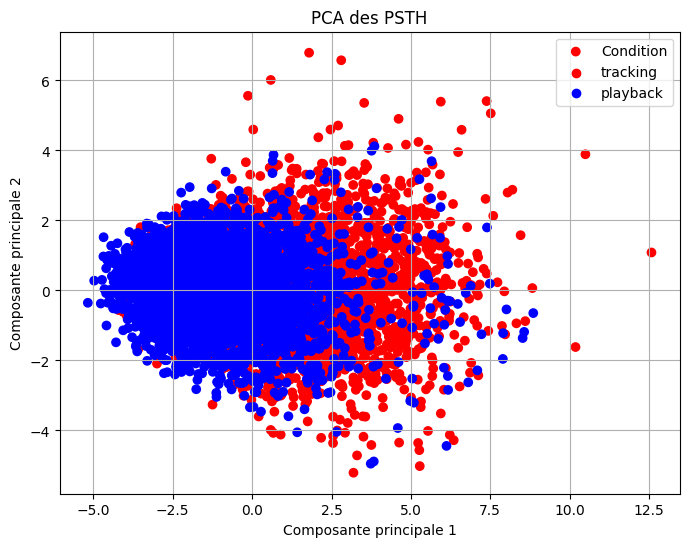

In [139]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

cluster = 4
tr_c0 = tracking[cluster]
tr_labels = np.zeros(len(tr_c0))
pb_c0 = playback[cluster]
pb_labels = np.ones(len(pb_c0))

c0 = np.vstack((tr_c0, pb_c0))
condition = np.hstack((tr_labels, pb_labels))

# Simulons quelques données PSTH pour plusieurs neurones
psth_data = c0

# Standardisation des données
scaler = StandardScaler()
psth_data_scaled = scaler.fit_transform(psth_data)

# Appliquer la PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(psth_data_scaled)

# Couleurs en fonction des conditions
colors = ['r' if cond == 0 else 'b' for cond in condition]

# Visualiser les résultats avec des couleurs différentes
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=colors, marker='o', label='Condition')

# Ajout de la légende et du titre
plt.title('PCA des PSTH')
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.grid(True)

# Ajout d'une légende pour les couleurs
plt.scatter([], [], c='r', label='tracking')
plt.scatter([], [], c='b', label='playback')
plt.legend()

plt.show()


In [140]:
# je fais la moyenne par cluster:
m_tracking = np.nanmean(tracking, axis=1)
baseline = []
for elt in m_tracking:
    baseline.append(get_sustained_activity_nan(elt, t_pre, t_post, bin_width))
    total_evoked_response = get_total_evoked_response(elt, t_pre, t_post, bin_width, 3, 20, 140)

IndexError: invalid index to scalar variable.

In [69]:
h = np.load('/auto/data2/eTheremin/MUROLS/MUROLS_20230220/MUROLS_20230220_SESSION_00/heatmap_plot_playback.npy')

In [18]:
total_evoked_response = get_total_evoked_response(m_tracking, t_pre, t_post, bin_width,50, 20, 140)

In [13]:
len(total_evoked_response)

26

In [14]:
gc

array([19, 10,  5, 23,  9, 13, 11, 24, 20, 30, 14,  8, 28,  7,  1,  4, 25,
        3,  6, 22, 29,  0, 27, 31, 26, 15])

In [19]:
total_evoked_response

[0.1440995450896441,
 0.20404067433770404,
 0.22812416376772812,
 0.20136473106770136,
 nan,
 nan,
 0.30371956114530374,
 0.30773347605030776,
 0.37235750602087236,
 0.4554455445544554,
 0.42507358843992504,
 0.4633395772009633,
 0.5140487021675141,
 0.6542681295156543,
 0.5493711533315493,
 0.5337168852020338,
 0.5147176879850147,
 0.5307733476050307,
 0.5603425207385604,
 nan,
 0.5128445276960129,
 0.5065560610115065,
 0.6332619748461332,
 0.5707786994915708,
 0.8011774150388011,
 0.6123896173401124]

In [ ]:
#séparer les clus + des -
baseline = 
peak = 
for clus, elt in enumerate(gc):
    if baseline<peak:   # positif
        
